In [ ]:
# ══ 1) Install / Upgrade Dependencies ════════════════════════════════════════
!pip install --upgrade pip
!pip install --quiet \
    opencv-python-headless \
    pandas \
    matplotlib \
    tqdm \
    scikit-learn \
    tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 31.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [ ]:
# ══ 2) Mount Google Drive ══════════════════════════════════════════════════
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# ══ 3) Imports & Global Settings ═══════════════════════════════════════════
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import re
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

# Paths & Hyperparameters
ROOT                 = '/content/drive/MyDrive/dataset/plantvillage dataset'
COLOR_DIR            = os.path.join(ROOT, 'grayscale')
SAVE_DIR             = '/content/drive/MyDrive/saved_models_gratscale_prod'
IMG_SIZE             = (224, 224)
BATCH_SIZE           = 32
NUM_HEAD_EPOCHS      = 15
NUM_FINE_TUNE_EPOCHS = 100
os.makedirs(SAVE_DIR, exist_ok=True)


In [ ]:

# ══ 3.1) Resume Helper & Callback Definition ════════════════════════════════
class EpochCheckpoint(Callback):
    """Save model and history after each epoch with unique names."""
    def __init__(self, save_dir, base_name):
        super().__init__()
        self.save_dir = save_dir
        self.base_name = base_name
        self.history_per_epoch = []

    def on_epoch_end(self, epoch, logs=None):
        ep = epoch + 1
        mpath = os.path.join(self.save_dir, f"{self.base_name}_{ep:02d}.h5")
        self.model.save(mpath)
        self.history_per_epoch.append(logs.copy() if logs else {})
        hpath = os.path.join(self.save_dir, f"history_{self.base_name}_{ep:02d}.pkl")
        with open(hpath, 'wb') as f:
            pickle.dump(self.history_per_epoch, f)


def find_last_checkpoint(save_dir, base_name):
    files = [f for f in os.listdir(save_dir) if re.match(f"{base_name}_\\d+\\.h5", f)]
    if not files:
        return None, None, 0
    epochs = [int(re.findall(r"(\\d+)", f)[0]) for f in files]
    last = max(epochs)
    mpath = os.path.join(save_dir, f"{base_name}_{last:02d}.h5")
    hpath = os.path.join(save_dir, f"history_{base_name}_{last:02d}.pkl")
    return mpath, hpath, last


In [ ]:
# ══ 4) Data Generators ═══════════════════════════════════════════════════════
datagen = ImageDataGenerator(
    rescale=1/255., rotation_range=20, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.1, zoom_range=0.1,
    horizontal_flip=True, validation_split=0.2
)
train_ds = datagen.flow_from_directory(
    COLOR_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', subset='training', shuffle=True
)
val_ds = datagen.flow_from_directory(
    COLOR_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', subset='validation', shuffle=False
)
NUM_CLASSES = train_ds.num_classes
print(f"Found {NUM_CLASSES} classes.")

Found 43456 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.
Found 38 classes.


In [ ]:
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.applications import MobileNetV2

# ══ 5) Build Base Model ══════════════════════════════════════════════════════
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(*IMG_SIZE, 3)
)
base_model.trainable = False

inputs = Input(shape=(*IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 38)             │        48,678 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,306,662 (8.80 MB)

 Trainable params: 48,678 (190.15 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# ══ 6) Stage-1: Head Training (Resumeable) ══════════════════════════════════
head_name = 'MobileNetV2_head'
mp, hp, e0 = find_last_checkpoint(SAVE_DIR, head_name)
if mp:
    print(f"Resuming head training from epoch {e0}")
    model.load_weights(mp)
    initial_ep = e0
else:
    print("Starting head training from scratch")
    initial_ep = 0
cb_head = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6),
    EpochCheckpoint(SAVE_DIR, head_name)
]
history1 = model.fit(
    train_ds, validation_data=val_ds,
    epochs=initial_ep + NUM_HEAD_EPOCHS,
    initial_epoch=initial_ep,
    callbacks=cb_head
)
print(f"Head training complete. Latest checkpoint: {head_name}_{initial_ep+NUM_HEAD_EPOCHS:02d}.h5")


Starting head training from scratch


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.7357 - loss: 0.9708 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 22582s 17s/step - accuracy: 0.7357 - loss: 0.9706 - val_accuracy: 0.8841 - val_loss: 0.3627 - learning_rate: 0.0010
Epoch 2/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.8911 - loss: 0.3359

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 656s 483ms/step - accuracy: 0.8911 - loss: 0.3359 - val_accuracy: 0.8880 - val_loss: 0.3345 - learning_rate: 0.0010
Epoch 3/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.9061 - loss: 0.2865

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 655s 482ms/step - accuracy: 0.9061 - loss: 0.2865 - val_accuracy: 0.9096 - val_loss: 0.2824 - learning_rate: 0.0010
Epoch 4/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.9127 - loss: 0.2618

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 653s 481ms/step - accuracy: 0.9127 - loss: 0.2618 - val_accuracy: 0.9122 - val_loss: 0.2667 - learning_rate: 0.0010
Epoch 5/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.9210 - loss: 0.2398

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 655s 482ms/step - accuracy: 0.9210 - loss: 0.2398 - val_accuracy: 0.9134 - val_loss: 0.2626 - learning_rate: 0.0010
Epoch 6/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.9241 - loss: 0.2206

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 652s 480ms/step - accuracy: 0.9241 - loss: 0.2206 - val_accuracy: 0.9128 - val_loss: 0.2777 - learning_rate: 0.0010
Epoch 7/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.9283 - loss: 0.2123

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 650s 478ms/step - accuracy: 0.9283 - loss: 0.2123 - val_accuracy: 0.9176 - val_loss: 0.2445 - learning_rate: 0.0010
Epoch 8/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.9276 - loss: 0.2133

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 656s 483ms/step - accuracy: 0.9276 - loss: 0.2133 - val_accuracy: 0.9117 - val_loss: 0.2678 - learning_rate: 0.0010
Epoch 9/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.9288 - loss: 0.2069

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 660s 486ms/step - accuracy: 0.9288 - loss: 0.2069 - val_accuracy: 0.9174 - val_loss: 0.2474 - learning_rate: 0.0010
Epoch 10/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.9372 - loss: 0.1771

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 659s 485ms/step - accuracy: 0.9372 - loss: 0.1771 - val_accuracy: 0.9187 - val_loss: 0.2402 - learning_rate: 5.0000e-04
Epoch 11/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.9413 - loss: 0.1719

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 656s 483ms/step - accuracy: 0.9413 - loss: 0.1719 - val_accuracy: 0.9204 - val_loss: 0.2327 - learning_rate: 5.0000e-04
Epoch 12/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.9408 - loss: 0.1708

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 652s 480ms/step - accuracy: 0.9408 - loss: 0.1708 - val_accuracy: 0.9259 - val_loss: 0.2287 - learning_rate: 5.0000e-04
Epoch 13/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.9416 - loss: 0.1655

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 652s 480ms/step - accuracy: 0.9416 - loss: 0.1655 - val_accuracy: 0.9237 - val_loss: 0.2312 - learning_rate: 5.0000e-04
Epoch 14/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.9431 - loss: 0.1628

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 654s 482ms/step - accuracy: 0.9431 - loss: 0.1629 - val_accuracy: 0.9237 - val_loss: 0.2382 - learning_rate: 5.0000e-04
Epoch 15/15
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.9467 - loss: 0.1539

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 655s 482ms/step - accuracy: 0.9467 - loss: 0.1539 - val_accuracy: 0.9323 - val_loss: 0.2051 - learning_rate: 2.5000e-04
Head training complete. Latest checkpoint: MobileNetV2_head_15.h5


Stage 1 final Train Accuracy: 0.9473, Validation Accuracy: 0.9323


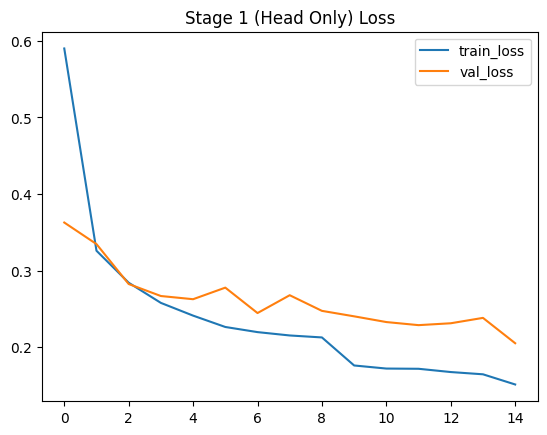

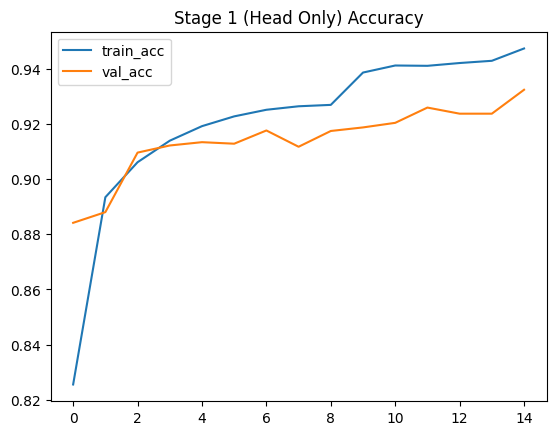

In [ ]:
# ══ 8) Plot & Print Stage-1 Metrics ═════════════════════════════════════════
def plot_history(hist, stage):
    plt.figure()
    plt.plot(hist.history['loss'], label='train_loss')
    plt.plot(hist.history['val_loss'], label='val_loss')
    plt.title(f'{stage} Loss'); plt.legend()
    plt.figure()
    plt.plot(hist.history['accuracy'], label='train_acc')
    plt.plot(hist.history['val_accuracy'], label='val_acc')
    plt.title(f'{stage} Accuracy'); plt.legend()

plot_history(history1, 'Stage 1 (Head Only)')
train_acc1 = history1.history['accuracy'][-1]
val_acc1   = history1.history['val_accuracy'][-1]
print(f"Stage 1 final Train Accuracy: {train_acc1:.4f}, Validation Accuracy: {val_acc1:.4f}")

In [ ]:
# ══ 9) Stage-2: Fine-Tuning (Resumeable) ═══════════════════════════════════
for layer in base_model.layers[-30:]:
    layer.trainable = True
model.compile(optimizer=keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
fine_name = 'rMobileNetV2_finetuned'
mp2, hp2, e1 = find_last_checkpoint(SAVE_DIR, fine_name)
if mp2:
    print(f"Resuming fine-tuning from epoch {e1}")
    model.load_weights(mp2)
    initial_ft = e1
else:
    print("Starting fine-tuning from scratch")
    initial_ft = 0
cb_ft = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7),
    EpochCheckpoint(SAVE_DIR, fine_name)
]
history2 = model.fit(
    train_ds, validation_data=val_ds,
    epochs=initial_ft + NUM_FINE_TUNE_EPOCHS,
    initial_epoch=initial_ft,
    callbacks=cb_ft
)
print(f"Fine-tuning complete. Latest checkpoint: {fine_name}_{initial_ft+NUM_FINE_TUNE_EPOCHS:02d}.h5")


Starting fine-tuning from scratch
Epoch 1/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.7893 - loss: 0.8058

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 679s 489ms/step - accuracy: 0.7893 - loss: 0.8056 - val_accuracy: 0.9112 - val_loss: 0.2731 - learning_rate: 1.0000e-05
Epoch 2/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.9038 - loss: 0.2852

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 656s 483ms/step - accuracy: 0.9038 - loss: 0.2852 - val_accuracy: 0.9217 - val_loss: 0.2395 - learning_rate: 1.0000e-05
Epoch 3/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.9251 - loss: 0.2233

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 657s 484ms/step - accuracy: 0.9251 - loss: 0.2233 - val_accuracy: 0.9295 - val_loss: 0.2179 - learning_rate: 1.0000e-05
Epoch 4/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.9357 - loss: 0.1860

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 649s 478ms/step - accuracy: 0.9357 - loss: 0.1860 - val_accuracy: 0.9313 - val_loss: 0.2016 - learning_rate: 1.0000e-05
Epoch 5/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.9422 - loss: 0.1679

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 653s 481ms/step - accuracy: 0.9422 - loss: 0.1678 - val_accuracy: 0.9389 - val_loss: 0.1803 - learning_rate: 1.0000e-05
Epoch 6/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.9482 - loss: 0.1491

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 649s 478ms/step - accuracy: 0.9482 - loss: 0.1491 - val_accuracy: 0.9452 - val_loss: 0.1709 - learning_rate: 1.0000e-05
Epoch 7/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.9507 - loss: 0.1392

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 660s 486ms/step - accuracy: 0.9507 - loss: 0.1392 - val_accuracy: 0.9461 - val_loss: 0.1624 - learning_rate: 1.0000e-05
Epoch 8/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.9569 - loss: 0.1249

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 650s 479ms/step - accuracy: 0.9569 - loss: 0.1249 - val_accuracy: 0.9468 - val_loss: 0.1608 - learning_rate: 1.0000e-05
Epoch 9/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.9600 - loss: 0.1140

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 655s 482ms/step - accuracy: 0.9600 - loss: 0.1140 - val_accuracy: 0.9524 - val_loss: 0.1442 - learning_rate: 1.0000e-05
Epoch 10/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.9643 - loss: 0.1020

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 651s 479ms/step - accuracy: 0.9643 - loss: 0.1020 - val_accuracy: 0.9529 - val_loss: 0.1375 - learning_rate: 1.0000e-05
Epoch 11/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.9661 - loss: 0.0956

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 655s 483ms/step - accuracy: 0.9661 - loss: 0.0956 - val_accuracy: 0.9519 - val_loss: 0.1427 - learning_rate: 1.0000e-05
Epoch 12/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.9688 - loss: 0.0904

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 651s 479ms/step - accuracy: 0.9688 - loss: 0.0904 - val_accuracy: 0.9558 - val_loss: 0.1337 - learning_rate: 1.0000e-05
Epoch 13/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.9701 - loss: 0.0841

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 655s 483ms/step - accuracy: 0.9701 - loss: 0.0841 - val_accuracy: 0.9559 - val_loss: 0.1357 - learning_rate: 1.0000e-05
Epoch 14/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.9736 - loss: 0.0765

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 656s 483ms/step - accuracy: 0.9736 - loss: 0.0765 - val_accuracy: 0.9582 - val_loss: 0.1265 - learning_rate: 1.0000e-05
Epoch 15/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.9741 - loss: 0.0752

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 651s 479ms/step - accuracy: 0.9741 - loss: 0.0752 - val_accuracy: 0.9578 - val_loss: 0.1243 - learning_rate: 1.0000e-05
Epoch 16/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.9757 - loss: 0.0671

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 654s 481ms/step - accuracy: 0.9757 - loss: 0.0671 - val_accuracy: 0.9616 - val_loss: 0.1227 - learning_rate: 1.0000e-05
Epoch 17/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.9768 - loss: 0.0648

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 650s 479ms/step - accuracy: 0.9768 - loss: 0.0648 - val_accuracy: 0.9585 - val_loss: 0.1251 - learning_rate: 1.0000e-05
Epoch 18/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.9791 - loss: 0.0605

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 655s 482ms/step - accuracy: 0.9791 - loss: 0.0605 - val_accuracy: 0.9597 - val_loss: 0.1225 - learning_rate: 1.0000e-05
Epoch 19/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.9800 - loss: 0.0581

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 652s 480ms/step - accuracy: 0.9800 - loss: 0.0581 - val_accuracy: 0.9621 - val_loss: 0.1136 - learning_rate: 1.0000e-05
Epoch 20/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.9804 - loss: 0.0562

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 654s 482ms/step - accuracy: 0.9804 - loss: 0.0562 - val_accuracy: 0.9642 - val_loss: 0.1094 - learning_rate: 1.0000e-05
Epoch 21/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.9813 - loss: 0.0539

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 654s 481ms/step - accuracy: 0.9813 - loss: 0.0539 - val_accuracy: 0.9663 - val_loss: 0.1071 - learning_rate: 1.0000e-05
Epoch 22/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.9806 - loss: 0.0541

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 653s 481ms/step - accuracy: 0.9806 - loss: 0.0541 - val_accuracy: 0.9638 - val_loss: 0.1111 - learning_rate: 1.0000e-05
Epoch 23/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.9840 - loss: 0.0478

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 659s 485ms/step - accuracy: 0.9840 - loss: 0.0478 - val_accuracy: 0.9644 - val_loss: 0.1133 - learning_rate: 1.0000e-05
Epoch 24/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.9864 - loss: 0.0419

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 653s 481ms/step - accuracy: 0.9864 - loss: 0.0419 - val_accuracy: 0.9649 - val_loss: 0.1105 - learning_rate: 5.0000e-06
Fine-tuning complete. Latest checkpoint: rMobileNetV2_finetuned_100.h5


In [ ]:
# ══ 10) Plot & Print Stage-2 Metrics ═════════════════════════════════════════
'''
plot_history(history2, 'Stage 2 (Fine-Tune)')
train_acc2 = history2.history['accuracy'][-1]
val_acc2   = history2.history['val_accuracy'][-1]
print(f"Stage 2 final Train Accuracy: {train_acc2:.4f}, Validation Accuracy: {val_acc2:.4f}")
'''

NameError: name 'plot_history' is not defined

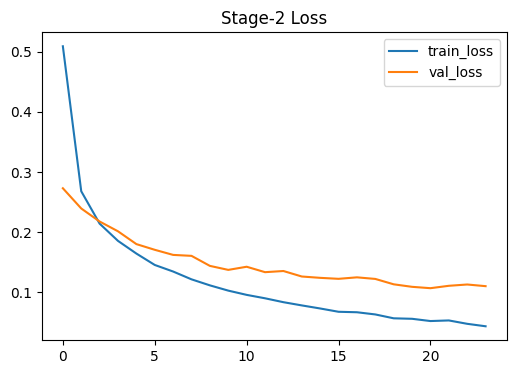

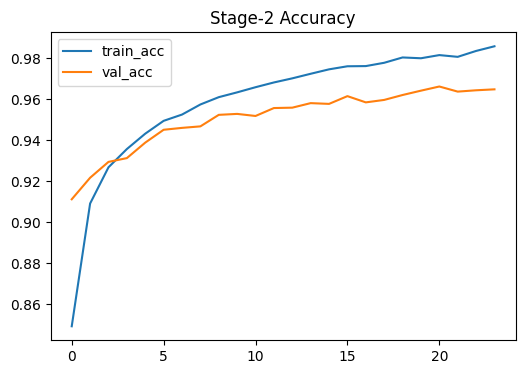

Stage 2 final Train Loss: 0.0439, Train Acc: 0.9859
           Val   Loss: 0.1105,   Val   Acc: 0.9649


In [ ]:
# 1) Imports
import pickle
import matplotlib.pyplot as plt
from tensorflow import keras
import os

# 2) Paths (update these to wherever your files live)
HISTORY_PATH = '/content/drive/MyDrive/saved_models_gratscale_prod/history_rMobileNetV2_finetuned_24.pkl'

MODEL_PATH   = '/content/drive/MyDrive/saved_models_gratscale_prod/rMobileNetV2_finetuned_24.h5'

# 3) Load history (this was saved as a list of per-epoch dicts)
with open(HISTORY_PATH, 'rb') as f:
    hist_list = pickle.load(f)

# 4) Extract metric lists
train_acc = [epoch.get('accuracy', epoch.get('iou_score')) for epoch in hist_list]
val_acc   = [epoch.get('val_accuracy', epoch.get('val_iou_score')) for epoch in hist_list]
train_loss = [epoch['loss']    for epoch in hist_list]
val_loss   = [epoch['val_loss'] for epoch in hist_list]

# 5) Plot
plt.figure(figsize=(6,4))
plt.plot(train_loss, label='train_loss')
plt.plot(val_loss,   label='val_loss')
plt.title('Stage-2 Loss'); plt.legend(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(train_acc, label='train_acc')
plt.plot(val_acc,   label='val_acc')
plt.title('Stage-2 Accuracy'); plt.legend(); plt.show()

# 6) Print final numbers
print(f"Stage 2 final Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}")
print(f"           Val   Loss: {val_loss[-1]:.4f},   Val   Acc: {val_acc[-1]:.4f}")

# 7) (Optional) Reload the model and run evaluate on your validation set
# from your earlier pipeline you might have val_ds defined already:
# model = keras.models.load_model(MODEL_PATH)
# loss, acc = model.evaluate(val_ds, steps=len(val_imgs)//BATCH_SIZE)
# print(f"Evaluate on val_ds -> Loss: {loss:.4f}, Acc: {acc:.4f}")


In [ ]:
val_loss, val_acc = model.evaluate(val_ds, verbose=1)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")


340/340 ━━━━━━━━━━━━━━━━━━━━ 130s 381ms/step - accuracy: 0.9704 - loss: 0.0867
Validation Loss: 0.1131, Validation Accuracy: 0.9624
